In [1]:
import math
import os
import re
import urllib

import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import numpy as np
import pandas as pd
import seaborn as sns
import tqdm
from lxml import html
from matplotlib.colors import LogNorm
from rdkit import Chem

In [2]:
tqdm.tqdm = tqdm.tqdm_notebook

In [3]:
plt.style.use(['seaborn-white', 'seaborn-paper'])
plt.rc('font', family='serif')
sns.set_palette('Set1')
sns.set_context('paper', font_scale=2.5)

In [4]:
def get_num_spectrum_files(task_id, extension=None):
    with urllib.request.urlopen(f'https://proteomics2.ucsd.edu/ProteoSAFe/'
                                f'status.jsp?task={task_id}') as f_url:
        num_files_str = html.fromstring(f_url.read()).xpath(
            '//th[text()="Spectrum Files"]/following-sibling::td/'
            'descendant::*/text()')
        return sum([1 for line in num_files_str
                    if extension is None
                    or line.strip().lower().endswith(extension.lower())])

In [5]:
def inchi_to_smiles(inchi):
    try:
        mol = Chem.rdinchi.InchiToMol(inchi)[0]
    except ValueError:
        mol = None
    return Chem.MolToSmiles(mol, True) if mol is not None else None

In [6]:
def get_score_annotations_count_map(compounds_list, score_thresholds, top):
    score_annotations_count_map = np.zeros((len(score_thresholds),
                                            len(compounds_list)))
    for file_i, compounds in enumerate(compounds_list):
        compounds_top = (compounds.sort_values(['#Scan#', 'MQScore'],
                                               ascending=[True, False])
                         .groupby('#Scan#').head(top))
        for threshold_i, score_threshold in enumerate(score_thresholds):
            score_annotations_count_map[threshold_i, file_i] =\
                len(compounds_top[compounds_top['MQScore'] >=
                                  score_threshold]['SMILES'].unique())
    return score_annotations_count_map

In [7]:
def plot_score_annotations_count_map(compounds_list, score_thresholds, top,
                                     num_files):
    fig, ax = plt.subplots(figsize=(9, 6))

    num_x_labels = len(num_files) // 5
    score_annotations_count_map = get_score_annotations_count_map(
        compounds_list, score_thresholds, top)
    sns.heatmap(score_annotations_count_map, square=False,
                cbar_kws={'label': 'Unique annotations'},
                xticklabels=[*num_files[0:-1:num_x_labels], num_files[-1]],
                yticklabels=[f'{c:0.1f}' for c in np.arange(0.5, 1.05, 0.1)],
#                 norm=LogNorm(vmin=score_annotations_count_map.min(),
#                              vmax=score_annotations_count_map.max()),
                cmap=sns.cm.rocket_r, ax=ax)
    
    ax.invert_yaxis()
    
    ax.xaxis.set_tick_params(rotation=0)
    ax.yaxis.set_tick_params(rotation=0)
    ax.xaxis.set_ticks_position('none')
    ax.yaxis.set_ticks_position('none')
    
    ax.xaxis.set_major_locator(mticker.IndexLocator(num_x_labels, 0))
    ax.yaxis.set_major_locator(mticker.AutoLocator())
    
#     fig.axes[-1].yaxis.set_major_locator(mticker.LogLocator())
#     fig.axes[-1].yaxis.set_minor_locator(mticker.LogLocator())
#     fig.axes[-1].yaxis.set_major_formatter(
#         mticker.StrMethodFormatter('{x:0.0f}'))

    ax.set_xlabel('Number of files considered')
    ax.set_ylabel('Cosine score')
    
    return fig, ax

Process dataset ICL_breath_cancer_Study_1


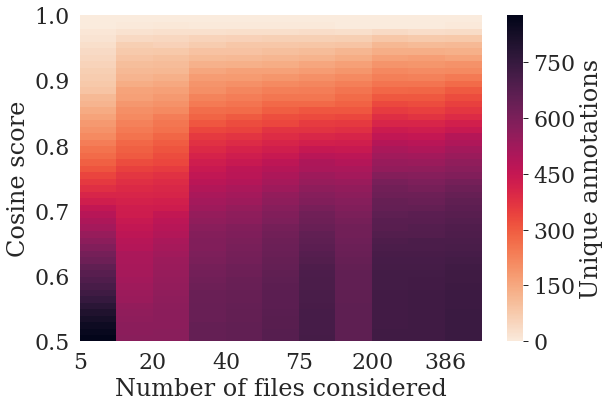

Process dataset UCDavis_combined


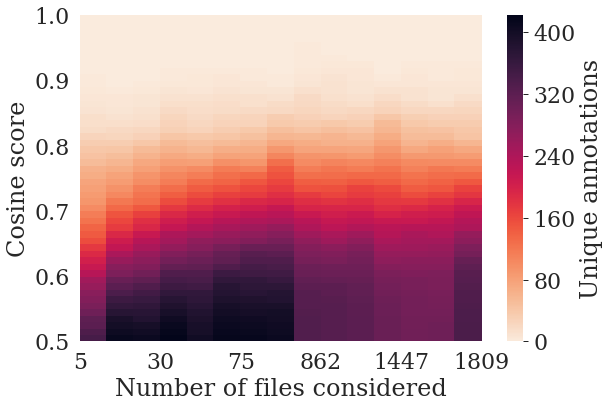

In [8]:
score_thresholds = np.arange(0.51, 1.01, 0.01)
for data_dir in ['../data/ICL_breath_cancer_Study_1',
                 '../data/UCDavis_combined']:
    dataset = data_dir[data_dir.rfind('/') + 1:]
    metadata = (pd.read_csv(os.path.join(data_dir, 'metadata.csv'))
                .dropna(subset=['GNPS deconvolution link',
                                'GNPS library search link']))
    print(f'Process dataset {dataset}')
    
    # Get all identifications for this dataset.
    compounds = []
    for library_link in tqdm.tqdm(metadata['GNPS library search link'],
                                  'Files loaded', unit='files'):
        task_id = library_link[library_link.rfind('=') + 1:][:8]
        filename = (f'MOLECULAR-LIBRARYSEARCH-GC-{task_id}'
                    f'-view_all_annotations_DB-main.tsv')
        compounds_file = (pd.read_csv(os.path.join(data_dir, filename),
                                      sep='\t',
                                      usecols=['#Scan#', 'INCHI', 'MQScore'],
                                      skipinitialspace=True)
                          .dropna())
        compounds_file['SMILES'] =\
            compounds_file['INCHI'].apply(inchi_to_smiles)
        compounds_file = compounds_file.drop('INCHI', 'columns').dropna()
        compounds.append(compounds_file)
    
    # Get the number of files for this dataset.
    num_files = [
        get_num_spectrum_files(
            deconvolution_link[deconvolution_link.rfind('=') + 1:], '.cdf')
        for deconvolution_link in metadata['GNPS deconvolution link']
    ]
    
    # Plot the number of unique annotations for each score threshold for this
    # dataset.
#     for top in (1, 10):
    top = 1
    fig, ax = plot_score_annotations_count_map(
        compounds, score_thresholds, top, num_files)

    plt.savefig(f'unique_annotations_{dataset}_top{top}.svg',
                dpi=300, bbox_inches='tight')
    plt.show()
    plt.close()